# CM50270 Reinforcement Learning
## Graded Assessment: Racetrack

In this notebook, I have implemented Double Q-learning with Prioritised Experience Replay and modified with Epsilon decay and Adaptive learning rate. This is a part of the assignment for CM50270 Reinforcement Learning, University of Bath. The custom environment was provided. The description of the environment along with the specification can be found below.



### Environment Description
Consider driving a race car around a turn on a racetrack. In order to complete the race as quickly as possible, you would want to drive as fast as you can but, to avoid running off the track, you must slow down while turning.

In our simplified racetrack environment, the agent is at one of a discrete set of grid positions. The agent also has a discrete speed in two directions, $x$ and $y$. So the state is represented as follows:
$$(\text{position}_y, \text{position}_x, \text{velocity}_y, \text{velocity}_x)$$

The agent collects a reward of -1 at each time step, an additional -10 for leaving the track (i.e., ending up on a black grid square in the figure below), and an additional +10 for reaching the finish line (any of the red grid squares). The agent starts each episode on a randomly selected grid-square on the starting line (green grid squares) with a speed of zero in both directions. At each time step, the agent can change its speed in both directions. Each speed can be changed by +1, -1 or 0, giving a total of nine actions. For example, the agent may increase its speed in the $x$ direction by -1 and its speed in the $y$ direction by +1. The agent's speed cannot be greater than +10 or less than -10 in either direction.

<img src="images/track_big.png" style="width: 600px;"/>


The agent's next state is determined by its current grid square, its current speed in two directions, and the changes it  makes to its speed in the two directions. This environment is stochastic. When the agent tries to change its speed, no change occurs (in either direction) with probability 0.2.

If the agent leaves the track, it is returned to a random start grid-square and has its speed set to zero in both directions; the episode continues. An episode ends only when the agent transitions to a goal grid-square.



### Environment Implementation
We have implemented the above environment in the `racetrack_env.py` file, for you to use in this coursework. Please use this implementation instead of writing your own, and please do not modify the environment.

We provide a `RacetrackEnv` class for your agents to interact with. The class has the following methods:
- **`reset()`** - this method initialises the environment, chooses a random starting state, and returns it. This method should be called before the start of every episode.
- **`step(action)`** - this method takes an integer action (more on this later), and executes one time-step in the environment. It returns a tuple containing the next state, the reward collected, and whether the next state is a terminal state.
- **`render(sleep_time)`** - this method renders a matplotlib graph representing the environment. It takes an optional float parameter giving the number of seconds to display each time-step. This method is useful for testing and debugging, but should not be used during training since it is *very* slow. **Do not use this method in your final submission**.
- **`get_actions()`** - a simple method that returns the available actions in the current state. Always returns a list containing integers in the range [0-8] (more on this later).

There are nine actions available to the agent in each state, as described above. However, to simplify the code, we have represented each of the nine actions as an integer in the range [0-8]. The table below shows the index of each action, along with the corresponding changes it will cause to the agent's speed in each direction.

<img src="images/action_grid.png" style="width: 250px;"/>

For example, taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

### Racetrack Code Example


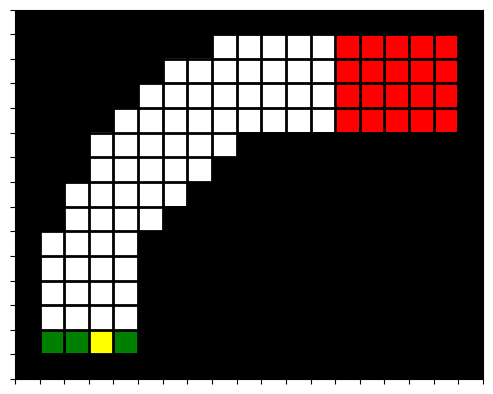

Initial State: (1, 3, 0, 0)


In [24]:
%matplotlib inline

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

from racetrack_env import RacetrackEnv

# Instantiate environment object.
env = RacetrackEnv()

# Initialise/reset environment.
state = env.reset()
env.render()
print("Initial State: {}".format(state))

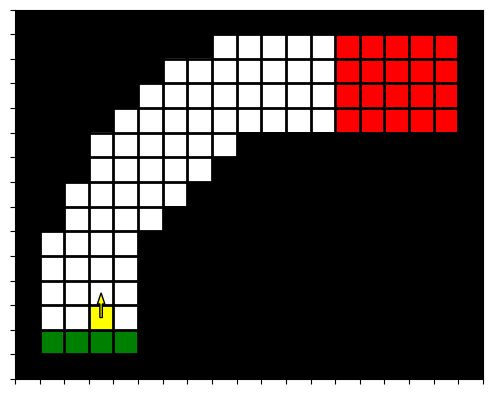

Next State: (2, 3, 1, 0), Reward: -1, Terminal: False


In [25]:
# Let us increase the agent's vertical speed (action 1).
next_state, reward, terminal = env.step(1)
env.render()
print("Next State: {}, Reward: {}, Terminal: {}".format(next_state, reward, terminal))

ß## Exercise: Modified Temporal-Difference Learning Agent 
### Implementation
In this exercise, you must implement a Temporal-Difference learning agent that learns to reach a goal state in the racetrack more efficiently than the Q-Learning agent shown above. 

#### Constraints
 However you go about improving your agent, it must still use a **tabular** Temporal-Difference learning method at its core (i.e., it should not make use of function approximation, neural networks etc.).

Please use the following parameter settings:
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 5.


You may adjust all other parameters as you see fit.


Your implementation of a tabular modified Temporal-Difference learning agent should produce a list named `modified_agent_rewards`. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent. <br />



### My solution: Double Q-learning with Prioritised Experience replay, Epsilon decay and Adaptive Learning rate

In [27]:
from collections import defaultdict, deque

In [6]:
class PERBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.0001, priority_max=1.0):
        """
        Initializes a Prioritized Experience Replay (PER) Buffer.
        Arguments:
        - capacity {int} -- The maximum size of the buffer.
        - alpha {float} -- The exponent α determining how much prioritization is used, default is 0.6.
        - beta {float} -- The exponent β for importance sampling weights, default is 0.4.
        - beta_increment {float} -- Increment value for β after each sample, default is 0.0001.
        - priority_max {float} -- The initial maximum priority for new entries, default is 1.0.
        """
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.priority_max = priority_max
        self.buffer_size = 0
        self.buffer = deque(maxlen=capacity)
        self.priority = np.zeros((capacity,), dtype=np.float32)
        self.probs = np.zeros((capacity,), dtype=np.float32)

    def size(self):
        """
        Returns the current size of the buffer.
        Returns:
        {int} -- The current size of the buffer.
        """
        return self.buffer_size

    def add(self, state, action, reward, next_state, terminal):
        """
        Adds a new experience to the buffer.
        Arguments:
        - state -- The current state.
        - action -- The action taken in the state.
        - reward -- The reward received after taking the action.
        - next_state -- The next state reached.
        - terminal {bool} -- Whether the next state is a terminal state.
        """
        priority_max_value = self.priority_max if self.buffer_size == 0 else self.priority.max()
        self.buffer.append((state, action, reward, next_state, terminal))
        self.buffer_size = np.minimum(self.buffer_size + 1, self.capacity)
        self.priority[self.buffer_size - 1] = priority_max_value
        self.update_probs()

    def update_probs(self):
        """
        Updates the probabilities of the experiences based on their priorities.
        """
        priority_pow = np.power(self.priority[:self.buffer_size], self.alpha)
        priority_sum = priority_pow.sum()
        self.probs[:self.buffer_size] = priority_pow / priority_sum

    def sample(self, batch_size):
        """
         Samples a batch of experiences from the buffer.
        Arguments:
        - batch_size {int} -- The number of experiences to sample.
        Returns:
        A tuple of (samples, weights, indexes):
        - samples -- A list of sampled experiences.
        - weights -- The importance-sampling weights for the sampled experiences.
        - indexes -- The indexes of the sampled experiences in the buffer.
        Raises:
        - ValueError: Raised if the buffer contains fewer elements than the requested batch size.
        """
        if self.buffer_size < batch_size:
            raise ValueError("Not enough elements :(")

        indexes = np.random.choice(self.buffer_size, batch_size, p=self.probs[:self.buffer_size])
        samples = [self.buffer[i] for i in indexes]
        weights = np.power(self.buffer_size * self.probs[indexes], -self.beta)
        self.beta = np.minimum(1.0, self.beta + self.beta_increment) # increment beta
        weights /= weights.max() # normalize weights

        return samples, weights, indexes

    def update_priorities(self, indexes, errors):
        """
        Updates the priorities of experiences at specified indexes.
        Arguments:
        - indexes {list} -- List of indexes of experiences to update.
        - errors {list} -- Corresponding errors to update priorities with.
        """
        margin = 1e-5
        for i, err in zip(indexes, errors):
            self.priority[i] = np.maximum(self.priority_max, np.abs(err) + margin)
        self.update_probs()


In [22]:
# Please write your code for Exercise 2a in this cell or in as many cells as you want ABOVE this cell.
# You should implement your modified TD learning agent here.
# Do NOT delete or duplicate this cell.

class DoubleQPER:
    def __init__(self, env, alpha_initial, gamma, eps, num_episodes, buffer_size, batch_size):
        """
        Initializes an instance of Double Q-Learning agent with Prioritized Experience Replay.
        Arguments:
        - env -- The environment to interact with.
        - alpha_initial {float} -- The initial learning rate.
        - gamma {float} -- The discount factor.
        - eps {float} -- The initial epsilon for the epsilon-greedy policy.
        - num_episodes {int} -- The number of episodes for training.
        - buffer_size {int} -- The size of the PER buffer.
        - batch_size {int} -- The batch size for sampling from the buffer.
        """
        self.num_act = len(env.get_actions())
        self.Q1 = defaultdict(lambda: np.zeros(self.num_act))
        self.Q2 = defaultdict(lambda: np.zeros(self.num_act))
        self.per_buffer = PERBuffer(capacity=buffer_size)
        self.alpha_init = alpha_initial
        self.gamma = gamma
        self.eps = eps
        self.num_episodes = num_episodes
        self.batch_size = batch_size
        self.env = env

    def get_greedy(self, Q_s):
        """
        Calculates the epsilon-greedy policy based on Q-values.
        Arguments:
        - Q_s {list} -- A list of Q-values for the state.
        Returns:
        {np.array} -- The probability distribution of actions under the epsilon-greedy policy.
        """
        policy = np.ones(self.num_act) * self.eps / self.num_act # create probability distribution
        # handle ties
        max_q_val = np.max(Q_s)
        max_indexes = np.where(Q_s == max_q_val)[0]
        best_act = np.random.choice(max_indexes)
        policy[best_act] += (1.0 - self.eps) # best action probs
        return policy

    def update_Q(self, Q_update, Q_other, state, action, reward, next_state, terminal, weight):
        """
        Updates the Q-values for a given state and action.
        Arguments:
        - Q_update, Q_other -- The two Q-tables being updated.
        - state, action, reward, next_state, terminal -- The current experience tuple.
        - weight {float} -- The importance-sampling weight of the experience.
        Returns:
        {defaultdict} -- The updated Q-table.
        """
        best_act = np.argmax(Q_other[next_state])
        target = reward + self.gamma * Q_other[next_state][best_act] * (not terminal) # bool mul to hadle terminal state 
        error = target - Q_update[state][action]
        alpha = self.update_learning_rate(error)
        Q_update[state][action] += alpha * error * weight
        return Q_update, error

    def update_learning_rate(self, error, min_alpha=0.1, max_alpha=1.0, decay=0.01):
        """
        Updates the learning rate based on the observed error.
        Arguments:
        - error {float} -- The observed TD error.
        - min_alpha {float} -- The minimum allowable learning rate.
        - max_alpha {float} -- The maximum allowable learning rate.
        - decay {float} -- The decay rate for the learning rate.
        Returns:
        {float} -- The updated learning rate.
        """
        alpha = self.alpha_init / (1 + decay * abs(error))
        return max(min_alpha, min(max_alpha, alpha))

    def run(self):
        """
        Runs the training process for the specified number of episodes.
        Returns:
        {list} -- A list containing the total reward for each episode.
        """
        rewards = []
        for i_episode in range(1, self.num_episodes + 1):
            state = self.env.reset()
            sum_reward = 0
            self.eps = max(self.eps ** 1.12, 0.005)

            while True:
                action = np.random.choice(self.num_act, p=self.get_greedy((self.Q1[state] + self.Q2[state]) / 2))
                next_state, reward, terminal = self.env.step(action)
                sum_reward += reward

                self.per_buffer.add(state, action, reward, next_state, terminal)

                if self.per_buffer.size() >= self.batch_size:
                    samples, weights, indexes = self.per_buffer.sample(self.batch_size)

                    for idx, (s_state, s_action, s_reward, s_next_state, s_terminal), weight in zip(indexes, samples, weights):
                         # randomly between q-tables                                                                           
                        if random.random() < 0.5:
                            self.Q1, error = self.update_Q(self.Q1, self.Q2, s_state, s_action, s_reward, s_next_state,
                                                    s_terminal, weight)
                        else:
                            self.Q2, error = self.update_Q(self.Q2, self.Q1, s_state, s_action, s_reward, s_next_state,
                                                    s_terminal, weight)
                        
                        self.per_buffer.update_priorities([idx], [error])
                
                state = next_state
                if terminal:
                    rewards.append(sum_reward)
                    break

        return rewards


alpha = 0.4
gamma = 1
eps = 0.7
num_episodes = 150
buffer_size = 10000
batch_size = 512

env = RacetrackEnv()  
modified_agent_rewards = []
for i in range(1, 10+1):
    print("\rAgent: ", i, end='', flush=True)
    agent = DoubleQPER(env, alpha, gamma, eps, num_episodes, buffer_size, batch_size)
    rewards = agent.run()
    modified_agent_rewards.append(rewards)

Agent:  10

### Comparison & Discussion



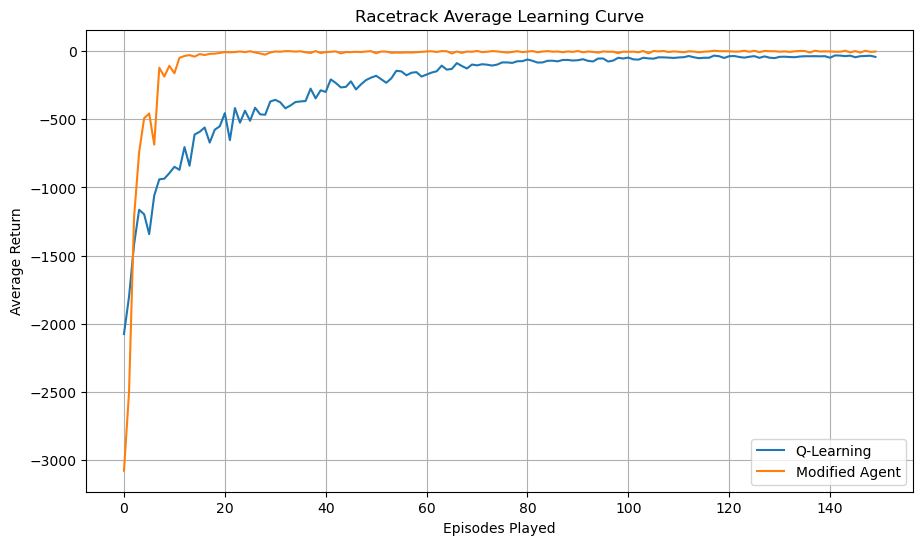

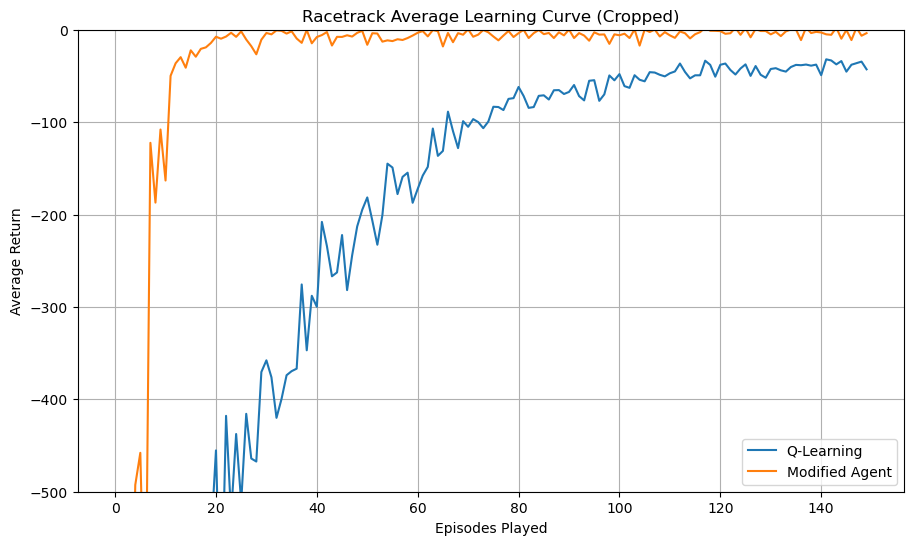

In [23]:
from racetrack_env import plot_modified_agent_results
from racetrack_env import simple_issue_checking

# Checking Modified Agent Results for Obvious Issues.
simple_issue_checking(modified_agent_rewards, modified_agent = True)

# Plotting Modified Agent Learning Curve.
%matplotlib inline
plot_modified_agent_results(modified_agent_rewards)

### Based on your results, and your understanding of the algorithm and modifications that you have implemented, please answer the following discussion questions. <br />

**Question 1:** What modifications did you make to your agent?

**Question 2:** What effect(s) did you expect your modifications to have on the performance of your agent?

**Question 3:** Did your modifications have the effect(s) you expected? Why do you think that this was the case?

**Question 4:** If you had more time, what would you do to further improve the performance of your agent?

Please do not exceed **60 words** for any of your answers.

Please note that **your implementation and discussion will be assessed jointly**. This means that, in order to score highly, you will need to correctly implement appropriate modifications to your agent **AND** discuss them well.

Please write your answers for Exercise 2b in this markdown cell.

**Answer 1:** 
I combined double q-learning with prioritised experience replay, adaptive learning rate and exponential epsilon decay. Double q-learning adds additional q-table to tackle overestimation. The prioritised replay is a buffer that samples previous experiences based on their probabilities and assigns weights to them using importance sampling to decrease the bias. Learning rate is adapted based on the error between target and actual estimate. 


**Answer 2:** 
I expected faster learning and convergence, along with a higher final return. The combination of PR and DQL was anticipated to facilitate more efficient and stable learning. An adaptive learning rate was intended to optimise and adjust the learning dynamics for smoother convergence. Epsilon decay aimed to introduce a variety of experiences into the buffer to increase the final return.

**Answer 3:** 
The graph shows the agent reaching near-peak performance within the first 20 episodes, quickly converging with small return improvements over time. The environment's simplicity likely limited the full potential of the modifications. The prioritised buffer slightly outperformed the simple replay buffer, requiring high importance sampling weights to reduce bias. An adaptive learning rate smoothed learning. The higher initial epsilon value increased final returns but slowed learning.


**Answer 4:** 
Honestly, there's a limit for performance improvement. My agent learns quickly and converges to a better policy. Slowing epsilon decay from 1.0 may yield higher returns by allowing slower learning and adding diverse experiences to the buffer. If I had time, I would experiment with implementing different algorithms like Dyna-Q/Plus and adding extra modifications like prioritized sweeping and n-step bootstrapping.
